Code for EE4540 Project assignment 

Standard imports

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy.io as sio
from tqdm import tqdm

# Project Description

Consider the situation where we randomly place sensors in a square area of $100 \times 100 \ \mathrm{m}^2$ to measure a certain quantity (e.g., temperature, density, etc.).

---

### • Design of a Connected Sensor Network

Design a properly **connected sensor network** that covers the area of the plant using a reasonable number of sensors.

- **Task**: How many sensors are needed to guarantee a connected sensor network?
- **Deliverable**: Motivate and justify your choice based on theoretical or empirical reasoning.

---

### • Average Consensus

Suppose the sensor network aims to compute the **average** value of the measurement data.

- Implement a **randomised gossip algorithm** as a baseline method.
- Then, implement the **average consensus problem** using the **PDMM (Primal-Dual Method of Multipliers)** algorithm.
- **Report**: Compare the performance in terms of convergence speed and number of transmissions between the two algorithms.

---

### • Median Consensus

Suppose the sensor network now aims to compute the **median** of the measurement data.

- Implement the **median consensus problem** using the **PDMM algorithm**.


# Plot of the placed sensors in the area

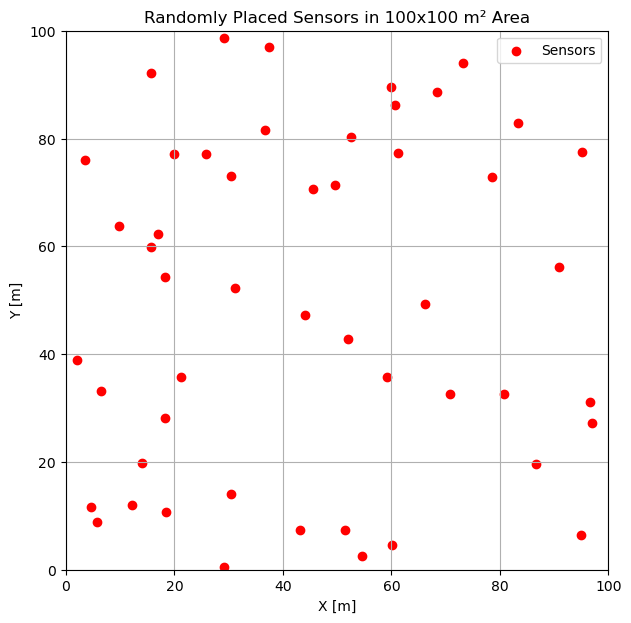

In [6]:
# Parameters
AREA_WIDTH = 100  # meters
num_sensors = 50  # Change this to your desired number of sensors

# Generate random sensor positions
np.random.seed(42)  # For reproducibility
sensor_x = np.random.uniform(0, AREA_WIDTH, num_sensors)
sensor_y = np.random.uniform(0, AREA_WIDTH, num_sensors)

coords = np.vstack((sensor_x, sensor_y)).T

# Plot the grid and sensor positions
plt.figure(figsize=(7, 7))
plt.scatter(x = coords[:,0], y = coords[:,1], c='red', label='Sensors')
plt.xlim(0, AREA_WIDTH)
plt.ylim(0, AREA_WIDTH)
plt.title(f'Randomly Placed Sensors in {AREA_WIDTH}x{AREA_WIDTH} m² Area')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True)
plt.legend()
plt.show()


# Connect the sensors that are close enough to each other

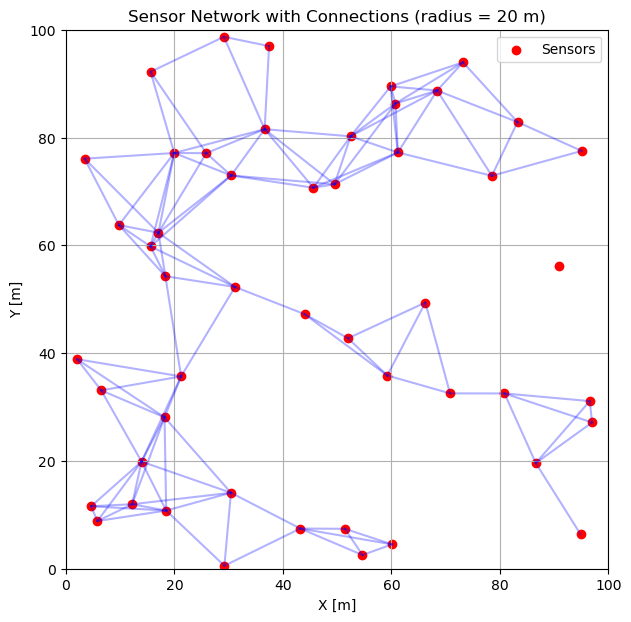

In [7]:
# Interconnect sensors that are within a certain communication radius
RADIUS = 20  # meters

plt.figure(figsize=(7, 7))
plt.scatter(x = coords[:,0], y = coords[:,1], c='red', label='Sensors')

# Vectorized computation of pairwise distances
coords = np.vstack((sensor_x, sensor_y)).T
dists = np.sqrt(np.sum((coords[:, None, :] - coords[None, :, :])**2, axis=-1))
adjacency = (dists <= RADIUS) & (dists > 0)

# Draw lines for all pairs within radius
for i in range(num_sensors):
    neighbors = np.where(adjacency[i])[0]
    for j in neighbors:
        if i < j:  # Avoid duplicate lines
            plt.plot([sensor_x[i], sensor_x[j]], [sensor_y[i], sensor_y[j]], 'b-', alpha=0.3)

plt.xlim(0, AREA_WIDTH)
plt.ylim(0, AREA_WIDTH)
plt.title(f'Sensor Network with Connections (radius = {RADIUS} m)')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True)
plt.legend()
plt.show()

A $d$-dimensional geometric random graph on $n$ nodes, denoted as $G^d(n, r)$, models a wireless ad-hoc network of nodes with wireless transmission radius $r$.

- Place $n$ nodes in a $d$-dimensional unit cube uniformly at random  
- Connect any two nodes that are within distance $r$ of each other  

---

### **Property:**

For $r^d \geq \dfrac{2 \log(n)}{n}$, the graph $G^d(n, r)$ is connected with probability at least  $1 - \dfrac{1}{n^2}$


In [19]:
# Compute minimum required radius for connectivity in 2D
n = num_sensors
DIMENSION = np.shape(coords)[1]  # Number of dimensions (2D in this case)
# Use np.power for general d-dimensional case
unit_cube_radius = np.power(2 * np.log(n) / n, 1 / DIMENSION)
required_radius = unit_cube_radius * AREA_WIDTH  # scale to area

print(f"Minimum required radius for connectivity with high probability (n={n}, area={AREA_WIDTH}x{AREA_WIDTH}): {required_radius:.2f} m")

Minimum required radius for connectivity with high probability (n=50, area=100x100): 39.56 m


In [61]:
# Given a desired communication radius, calculate the minimum number of sensors for connectivity (with high probability)

DESIRED_RADIUS = 20  # meters, set your desired radius here
DIMENSION = np.shape(coords)[1]  # Number of dimensions (2D in this case)

# Rearranged formula: n >= 2 * log(n) / (r^d)
# We'll solve for n numerically since n appears on both sides

def min_sensors_for_radius(desired_radius, area_width, dimension):
    unit_radius = desired_radius / area_width
    radius_term = 0.5*unit_radius ** dimension

    # Use a simple iterative approach
    n_guess = 2
    while True:
        n_term = np.log(n_guess) / n_guess
        if radius_term >= n_term:
            return n_guess
        n_guess += 1

min_n = min_sensors_for_radius(DESIRED_RADIUS,AREA_WIDTH, DIMENSION)
print(f"Minimum number of sensors for radius {DESIRED_RADIUS} m and area {AREA_WIDTH}x{AREA_WIDTH}: {min_n}")

probability_of_connectivity = (1 - 1 / min_n**2)*100  # Simplified probability of connectivity

print(f"Probability of connectivity with {num_sensors} sensors and radius {DESIRED_RADIUS} m: {probability_of_connectivity:.4f}%")

Minimum number of sensors for radius 20 m and area 100x100: 283
Probability of connectivity with 50 sensors and radius 20 m: 99.9988%


# Randomized Gossip Implementation

### Add randomized data to the coordinate points

(50, 50)


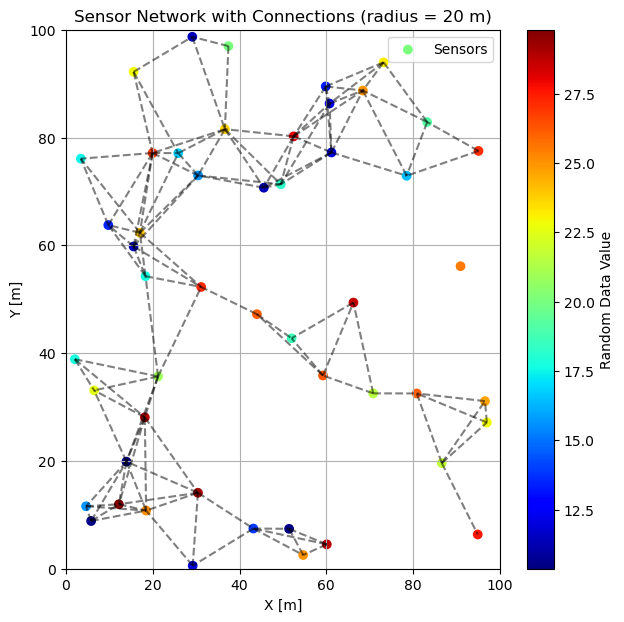

In [13]:
# coords has shape (N, 2)
random_column = np.random.uniform(low=10, high=30, size=(coords.shape[0], 1))  # shape (N, 1)

# concatenate along axis=1 (columns)
coords_augmented = np.hstack((coords, random_column))  # shape (N, 3)

# Compute pairwise distances
dists = np.sqrt(np.sum((coords_augmented[:, None, 0:2] - coords_augmented[None, :, 0:2])**2, axis=-1))

print(dists.shape)
adjacency = (dists <= RADIUS) & (dists > 0)

# Create figure
plt.figure(figsize=(7, 7))

# Scatter plot with color based on random data
sc = plt.scatter(sensor_x, sensor_y, c=coords_augmented[:,2].flatten(), cmap='jet', label='Sensors')

# Draw dashed black lines for connected sensors
for i in range(num_sensors):
    neighbors = np.where(adjacency[i])[0]
    for j in neighbors:
        if i < j:  # Avoid duplicates
            plt.plot([sensor_x[i], sensor_x[j]], [sensor_y[i], sensor_y[j]], 'k--', alpha=0.5)

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Random Data Value')

# Final plot settings
plt.xlim(0, AREA_WIDTH)
plt.ylim(0, AREA_WIDTH)
plt.title(f'Sensor Network with Connections (radius = {RADIUS} m)')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True)
plt.legend()
plt.show()

